Esse notebook tem como objetivo o desenvolvimento do segundo modelo de behavior solicitados pela claro para avaliar se clientes pré-pago virariam ou não inadimplentes ao migrar para plano controle.
Esse modelo irá utilizar toda a base BUREAU disponibilizada


#BIBLIOTECAS E INSTALAÇÕES

In [ ]:
#configurando ambiente spark:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# manipulação, leitura e vizualização de dados bibiliotecas
import pandas as pd
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

In [ ]:
# Configurar o Pandas para não usar notação científica para floats e exibir com 2 casas decimais
pd.set_option('display.float_format', '{:.6f}'.format)
#pd.set_option('display.max_rows', 74)
#pd.set_option('display.max_columns', 68)
#pd.reset_option('display.width')
#pd.reset_option('display.max_colwidth')

In [ ]:
#machilne learning bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier # Using GradientBoostingClassifier as inferred from later use
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.6 MB/s eta 0:00:00


#FUNÇÕES

In [ ]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes.astype(str), # Convert dtypes to string for sorting
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': ((dataframe.isnull().sum() / len(dataframe)) * 100).round(2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [ ]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# LEITURA E PADRONIZAÇÃO DA BASE DE DADOS

In [ ]:
#conectando com google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#lendo dataset
df_bureal = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_score_bureau_movel/base_score_bureau_movel/BASECPFUNICOparquetunico/part-00000-98e88720-cfb7-4d91-aadf-a26be5bb24ce-c000.snappy.parquet')

In [ ]:
#tamanho do dataset
df_bureal.shape

(1272095, 5)

In [ ]:
#vendo 5 primeiras linhas
df_bureal.head(5)

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


- O Grupo controle será removido da base do modelo uma vez que é um grupo de pessoas em que o modelo não é aplicado.
- O grupo controle pode ser identificado a partir do 6º e 7º dígitos do CPF, considerando as combinações ZZ e ZX.

In [ ]:
# Filtra o DataFrame para remover linhas onde o 6º e 7º dígitos de NUM_CPF são 'ZZ' ou 'ZX'
df_bureal_sem_grupo_controle = df_bureal[~df_bureal['NUM_CPF'].str[5:7].isin(['ZZ', 'ZX'])]

# Exibe o novo formato do DataFrame para verificar
print(f"Shape of df_bureal_sem_grupo_controle_pd (rows, columns): {df_bureal_sem_grupo_controle.shape}")
display(df_bureal_sem_grupo_controle.head())

Shape of df_bureal_sem_grupo_controle_pd (rows, columns): (1213448, 5)


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


In [ ]:
#% de CPFs que pertecem ao grupo controle:
original_num_rows = 1272095
filtered_num_rows = df_bureal_sem_grupo_controle.shape[0]

control_group_count = original_num_rows - filtered_num_rows
percentage_control_group = (control_group_count / original_num_rows) * 100

print(f"CPFS que pertencem ao grupo controle: {control_group_count}")
print(f"% CPFS do grupo controle em relação ao total da base: {percentage_control_group:.2f}%")

CPFS que pertencem ao grupo controle: 58647
% CPFS do grupo controle em relação ao total da base: 4.61%


In [ ]:
#GERANDO METADADOS DA TABELA:
generate_metadata(df_bureal_sem_grupo_controle)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.000000,1213448
1,SAFRA,object,0,0.000000,6
2,FPD_SCORE,object,0,0.000000,2
3,SCORE_01,object,8216,0.680000,296
4,SCORE_02,object,518,0.040000,584


In [ ]:
#tranformando tipo de dados das colunas para o mais adequado pre-processamento
import pandas as pd

# 1. Create a new column 'SAFRA_DATA' from 'SAFRA' in datetime format
df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')

# 2. Convert 'FPD_SCORE', 'SCORE_01', and 'SCORE_02' to nullable integer types
# Use errors='coerce' to turn unparseable values into NaN, and Int64Dtype to preserve NaNs
df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_01'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_01'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())

# Display the dtypes to verify the changes
print(df_bureal_sem_grupo_controle.dtypes)

# Display the head to see the new SAFRA_DATA column
display(df_bureal_sem_grupo_controle.head())

/tmp/ipython-input-2940056879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')
/tmp/ipython-input-2940056879.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
/tmp/ipython-input-2940056879.py:10: SettingWithCopyWarning: 
A value is trying to be set on

NUM_CPF               object
SAFRA                 object
FPD_SCORE              Int64
SCORE_01               Int64
SCORE_02               Int64
SAFRA_DATA    datetime64[ns]
dtype: object


/tmp/ipython-input-2940056879.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01


In [ ]:
#Foi detectado no EDA que o SCORE 1 tem muitas linhas com valor 0 e também com valor 2, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)

/tmp/ipython-input-1078160896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)


In [ ]:
#Foi detectado no EDA que o SCORE 2 tem muitas linhas com valor 1, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_02'] = df_bureal_sem_grupo_controle['SCORE_02'].replace([1], np.nan)

/tmp/ipython-input-1195080068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = df_bureal_sem_grupo_controle['SCORE_02'].replace([1], np.nan)


In [ ]:
#GERANDO ESTATISTICAS:
df_bureal_sem_grupo_controle.describe(include = 'all')

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
count,1213448,1213448,1213448.000000,1203051.000000,1212065.000000,1213448
unique,1213448,6,<NA>,<NA>,<NA>,NaN
top,999998YZYNW,202412,<NA>,<NA>,<NA>,NaN
freq,1,214502,<NA>,<NA>,<NA>,NaN
mean,NaN,NaN,0.227489,589.268532,630.341749,2024-12-16 04:58:03.537160192
min,NaN,NaN,0.000000,403.000000,307.000000,2024-10-01 00:00:00
25%,NaN,NaN,0.000000,556.000000,560.000000,2024-11-01 00:00:00
50%,NaN,NaN,0.000000,588.000000,625.000000,2024-12-01 00:00:00
75%,NaN,NaN,0.000000,622.000000,698.000000,2025-02-01 00:00:00
max,NaN,NaN,1.000000,778.000000,917.000000,2025-03-01 00:00:00


#Modelo 2 -> TABELA bureau  COM SCORE 01 E SCORE 02

### PREPARAÇÃO DOS DADOS

In [ ]:
#primeiramente vamos remover a coluna SCORE_02 do dataset para executar o primeiro modelo:
df_bureal_2 = df_bureal_sem_grupo_controle.copy()
df_bureal_2

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01
...,...,...,...,...,...,...
1272090,99997YWXNZZ,202503,0,604,674,2025-03-01
1272091,99998TYXZN8,202503,0,688,765,2025-03-01
1272092,9999888YYU9,202503,0,616,630,2025-03-01
1272093,9999889ZN9X,202503,0,627,649,2025-03-01


In [ ]:
# Definir a data de corte para a divisão OOT (Out-of-Time)
# O teste será fevereiro e março de 2025, então o treino será antes de fevereiro de 2025.
cutoff_date = pd.to_datetime('2025-02-01')

# Dividir o dataset em treino e teste
df_bureal_2_train = df_bureal_2[df_bureal_2['SAFRA_DATA'] < cutoff_date]
df_bureal_2_test = df_bureal_2[df_bureal_2['SAFRA_DATA'] >= cutoff_date]

# Exibir o shape dos datasets resultantes para verificação
print(f"Shape do dataset de treino (df_bureal_2_treino): {df_bureal_2_train.shape}")
print(f"Shape do dataset de teste (df_bureal_2_teste): {df_bureal_2_test.shape}")

# Exibir as primeiras linhas de cada dataset para verificar as datas
print("\nPrimeiras linhas do dataset de treino:")
display(df_bureal_2_train.head())
print("\nPrimeiras linhas do dataset de teste:")
display(df_bureal_2_test.head())

Shape do dataset de treino (df_bureal_1_treino): (822317, 6)
Shape do dataset de teste (df_bureal_1_teste): (391131, 6)

Primeiras linhas do dataset de treino:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01



Primeiras linhas do dataset de teste:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
862699,ZZZZZUXUXNN,202502,0,614,709,2025-02-01
862700,ZZZZZUUNY89,202502,0,591,594,2025-02-01
862701,ZZZZZU7UWZU,202502,0,615,721,2025-02-01
862702,ZZZZZU8Y7T7,202502,0,602,650,2025-02-01
862703,ZZZZZTZZYUZ,202502,0,516,580,2025-02-01


In [ ]:
#declarando x e y
X2_train = df_bureal_2_train[['SCORE_01','SCORE_02']]
y2_train = df_bureal_2_train['FPD_SCORE']
X2_test = df_bureal_2_test[['SCORE_01','SCORE_02']]
y2_test = df_bureal_2_test['FPD_SCORE']

In [ ]:
#definindo tipos de colunas em listas para preprocessamento dos dados
numerical_features = ['SCORE_01','SCORE_02']
rate_features = []
ordinal_features = []
categorical_features = []


In [ ]:
# Tratamento e Preparação dos Dados
# Define pipeline de data prep para variáveis numéricas
num_pipeline = Pipeline([
    ('imputernum', SimpleImputer(strategy='mean')), # Como outliers que realmente são erros foram tratados, inputando a média para retratar melhor toda população
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Junta as estratégias de data prep de todos os tipos de coluna com o ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numtransf", num_pipeline, numerical_features)
    ],
    remainder='passthrough' # Mantém demais colunas do dataset se eles existirem
)
#Encapsulamento do Preprocessador em um Pipeline
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])

#Aplicação do Pré-processamento aos Dados de Treino e Teste
X_train_2_processed = pd.DataFrame(preprocesssor.fit_transform(X2_train, y2_train),columns=X2_train.columns)
X_test_2_processed = pd.DataFrame(preprocesssor.transform(X2_test),columns=X2_test.columns)

#Concatenação dos Dados Processados
X_processed = pd.concat([X_train_2_processed,X_test_2_processed],axis=0)

#Aplicação do Pré-processamento aos Dados de Produção(para aplicar em base futura)
#X_prod_processed = pd.DataFrame(preprocesssor.transform(df_escoragem),columns=X1_test.columns)

In [ ]:
# Testar principais modelos de machile learning para problemas de classificacao apenas modificando o parametro
# que ajuda em trabalhar com classes desbalanceadas

# Calculate scale_pos_weight
count_neg = (y2_train == 0).sum()
count_pos = (y2_train == 1).sum()
scale_pos_weight_value = count_neg / count_pos

algoritmos = [DecisionTreeClassifier(random_state=0, class_weight='balanced'),
              LogisticRegression(random_state=0,class_weight='balanced'),
              RandomForestClassifier(random_state=0, class_weight='balanced'),
              GradientBoostingClassifier(random_state=0),
              XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value),
              lgb.LGBMClassifier(random_state=0,is_unbalance=True),
              cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0)
              ]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_2_processed,y2_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_2_processed, y2_train, X_test_2_processed, y2_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.665656,0.380681,0.742098,0.771835,0.543669,0.385250
1,DecisionTreeClassifier,Teste,0.616752,0.312538,0.579926,0.637097,0.274194,0.208919


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.627261,0.341380,0.681660,0.702018,0.404036,0.293182
1,LogisticRegression,Teste,0.637375,0.340513,0.645253,0.694299,0.388597,0.281710


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.687006,0.394174,0.692121,0.768090,0.536180,0.380513
1,RandomForestClassifier,Teste,0.640256,0.320973,0.530413,0.640726,0.281452,0.208833


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.775100,0.561012,0.066301,0.703212,0.406424,0.295440
1,GradientBoostingClassifier,Teste,0.776407,0.559388,0.050452,0.694946,0.389892,0.283706


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.631525,0.345481,0.687266,0.708514,0.417028,0.302484
1,XGBClassifier,Teste,0.638993,0.341293,0.642210,0.694079,0.388158,0.281782


[LightGBM] [Info] Number of positive: 187645, number of negative: 634672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 822317, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228191 -> initscore=-1.218556
[LightGBM] [Info] Start training from score -1.218556


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.631396,0.344216,0.679810,0.704631,0.409261,0.297127
1,LGBMClassifier,Teste,0.641417,0.342905,0.640162,0.695181,0.390361,0.283539


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,<catboost.core.CatBoostClassifier object at 0x...,Treino,0.630289,0.344582,0.687516,0.707871,0.415742,0.301102
1,<catboost.core.CatBoostClassifier object at 0x...,Teste,0.638602,0.341149,0.643217,0.694019,0.388038,0.282150


## Tunagem de hiperparâmetros

In [ ]:
#bibiloteca para fazer tunagem de hiperparametros

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

Como nesse problema o principal foco é o indicador KS, os modelos que tiveram a melhor perfomance inicial foram o LightGBM e o GradienteBoosting com uma leve vantagem para o GradientBoosting, porém, como o LightGBM é muito mais rapido de processamento que o GradientBoosting, o LightGBM foi selecionado para treinamento dos hiperparametros.

In [ ]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
# selecionando diferentes range dos parametros que serão testados para otimizar performance do algoritmo
    param = {
        "objective": "binary",
        "metric": "ks",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 20.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 20.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
    avg_ks = 0
    for i, (tr, ts) in enumerate(cv.split(X2_train, y2_train)):
        Xtr, Xvl = X2_train.iloc[tr], X2_train.iloc[ts]
        ytr, yvl = y2_train.iloc[tr], y2_train.iloc[ts]
        model = lgb.LGBMClassifier(**param,random_state = 0)
        Xtr_processed = pd.DataFrame(preprocesssor.fit_transform(Xtr, ytr),columns=X2_train.columns)
        Xvl_processed = pd.DataFrame(preprocesssor.transform(Xvl),columns=X2_test.columns)
        model.fit(Xtr_processed,ytr)
        p = model.predict_proba(Xvl_processed)[:, 1]

        # Calculate KS statistic
        df_temp = pd.DataFrame({'true_labels': yvl, 'predicted_probs': p})
        df_temp = df_temp.sort_values(by='predicted_probs', ascending=False)

        # Explicitly convert to float to ensure correct arithmetic for KS calculation
        total_true = df_temp['true_labels'].astype(float).sum()
        total_false = (1 - df_temp['true_labels'].astype(float)).sum()

        # Handle case where a fold might not have any positive or negative samples (though unlikely with StratifiedKFold)
        cumulative_true = df_temp['true_labels'].astype(float).cumsum() / total_true if total_true > 0 else 0
        cumulative_false = (1 - df_temp['true_labels'].astype(float)).cumsum() / total_false if total_false > 0 else 0

        ks_statistic = max(abs(cumulative_true - cumulative_false))

        print(f"Fold {i+1} KS: {ks_statistic}") # Added print statement
        avg_ks += ks_statistic # Add KS statistic

    print(f"Total avg_ks before division: {avg_ks/5}") # Added print statement
    return avg_ks/5 # Return average KS
#treinando os hiperparametros:
study = optuna.create_study(direction="maximize",study_name="modelo_2", storage="sqlite:///modelo)2.db", load_if_exists=True)
study.add_trials(study.trials)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])

    # reload study and optimize
    # study = optuna.load_study(study_name="pod-academy-study", storage="sqlite:///example.db")
    # study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-31 21:13:22,327] A new study created in RDB with name: modelo_2


Fold 1 KS: 0.29615230079925275
Fold 2 KS: 0.2920989090635601
Fold 3 KS: 0.29858659042383245
Fold 4 KS: 0.29403780286036735


[I 2026-01-31 21:14:14,802] Trial 0 finished with value: 0.29424245459296144 and parameters: {'lambda_l1': 1.4685305767589037e-08, 'lambda_l2': 1.1705513413208433, 'num_leaves': 52, 'feature_fraction': 0.17641924606627124, 'bagging_fraction': 0.17896521739029808, 'bagging_freq': 8, 'min_child_samples': 88}. Best is trial 0 with value: 0.29424245459296144.


Fold 5 KS: 0.29033666981779443
Total avg_ks before division: 0.29424245459296144
Fold 1 KS: 0.29587601347013304
Fold 2 KS: 0.29216311948811713
Fold 3 KS: 0.2992234939072184
Fold 4 KS: 0.2937465235549379


[I 2026-01-31 21:15:25,740] Trial 1 finished with value: 0.29452262435316756 and parameters: {'lambda_l1': 1.2069848797017477e-05, 'lambda_l2': 3.458205169268988e-08, 'num_leaves': 88, 'feature_fraction': 0.17823493253608108, 'bagging_fraction': 0.8500985624366088, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 1 with value: 0.29452262435316756.


Fold 5 KS: 0.2916039713454312
Total avg_ks before division: 0.29452262435316756
Fold 1 KS: 0.2957945225186095
Fold 2 KS: 0.2921253198048107
Fold 3 KS: 0.2993843888042089
Fold 4 KS: 0.29409006574046637


[I 2026-01-31 21:16:58,922] Trial 2 finished with value: 0.294659666791048 and parameters: {'lambda_l1': 5.1816336905538115e-08, 'lambda_l2': 2.7880133727845733e-07, 'num_leaves': 241, 'feature_fraction': 0.638177559229916, 'bagging_fraction': 0.8485191103350715, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 2 with value: 0.294659666791048.


Fold 5 KS: 0.29190403708714446
Total avg_ks before division: 0.294659666791048
Fold 1 KS: 0.29602575389649727
Fold 2 KS: 0.29292024083877993
Fold 3 KS: 0.29962248136901537
Fold 4 KS: 0.2925924112103166


[I 2026-01-31 21:17:48,581] Trial 3 finished with value: 0.2943085809616745 and parameters: {'lambda_l1': 1.9781008319288834e-08, 'lambda_l2': 3.4590834392828e-08, 'num_leaves': 80, 'feature_fraction': 0.8735703781812469, 'bagging_fraction': 0.6308069184127485, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 2 with value: 0.294659666791048.


Fold 5 KS: 0.2903820174937636
Total avg_ks before division: 0.2943085809616745
Fold 1 KS: 0.2954595976928956
Fold 2 KS: 0.2923016023816807
Fold 3 KS: 0.2996853569945457
Fold 4 KS: 0.29410073999263103


[I 2026-01-31 21:19:18,297] Trial 4 finished with value: 0.2947566954452917 and parameters: {'lambda_l1': 6.639806178997666e-05, 'lambda_l2': 0.1510215768381766, 'num_leaves': 245, 'feature_fraction': 0.38449481496104626, 'bagging_fraction': 0.5653558957636331, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 4 with value: 0.2947566954452917.


Fold 5 KS: 0.2922361801647055
Total avg_ks before division: 0.2947566954452917
Fold 1 KS: 0.2960974464617572
Fold 2 KS: 0.29171822148955
Fold 3 KS: 0.29914627272829614
Fold 4 KS: 0.2941901835880812


[I 2026-01-31 21:20:19,522] Trial 5 finished with value: 0.2944125532628755 and parameters: {'lambda_l1': 7.6213339958382385, 'lambda_l2': 1.7186008394804347e-07, 'num_leaves': 231, 'feature_fraction': 0.12460761768425493, 'bagging_fraction': 0.29806407367162585, 'bagging_freq': 8, 'min_child_samples': 37}. Best is trial 4 with value: 0.2947566954452917.


Fold 5 KS: 0.29091064204669315
Total avg_ks before division: 0.2944125532628755
Fold 1 KS: 0.29609448093692176
Fold 2 KS: 0.2926419953858075
Fold 3 KS: 0.2998498938038806
Fold 4 KS: 0.29438677632136345


[I 2026-01-31 21:21:03,738] Trial 6 finished with value: 0.2949742519152043 and parameters: {'lambda_l1': 5.252432899366792, 'lambda_l2': 3.088441865841341e-05, 'num_leaves': 32, 'feature_fraction': 0.3176090750328192, 'bagging_fraction': 0.6770440889169941, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 6 with value: 0.2949742519152043.


Fold 5 KS: 0.2918981131280483
Total avg_ks before division: 0.2949742519152043
Fold 1 KS: 0.29590570923284254
Fold 2 KS: 0.2923648706900445
Fold 3 KS: 0.29914139564319037
Fold 4 KS: 0.29423843761464163


[I 2026-01-31 21:22:24,132] Trial 7 finished with value: 0.2946362057650005 and parameters: {'lambda_l1': 0.0005611990482189547, 'lambda_l2': 2.720862750473637, 'num_leaves': 194, 'feature_fraction': 0.1412083362131269, 'bagging_fraction': 0.5227774755665647, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 6 with value: 0.2949742519152043.


Fold 5 KS: 0.2915306156442834
Total avg_ks before division: 0.2946362057650005
Fold 1 KS: 0.29594806415710095
Fold 2 KS: 0.29235980702542486
Fold 3 KS: 0.2991241565443632
Fold 4 KS: 0.2938855226846168


[I 2026-01-31 21:23:36,610] Trial 8 finished with value: 0.2946274961008962 and parameters: {'lambda_l1': 0.0001303731523671889, 'lambda_l2': 1.6837968578386464e-07, 'num_leaves': 94, 'feature_fraction': 0.3327629356214487, 'bagging_fraction': 0.8553229541873255, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 6 with value: 0.2949742519152043.


Fold 5 KS: 0.2918199300929751
Total avg_ks before division: 0.2946274961008962
Fold 1 KS: 0.2970991059517799
Fold 2 KS: 0.29159871442829527
Fold 3 KS: 0.3010471792570622
Fold 4 KS: 0.2932757199496123


[I 2026-01-31 21:24:23,236] Trial 9 finished with value: 0.29503715602488995 and parameters: {'lambda_l1': 1.2009054699395167, 'lambda_l2': 0.00047377296458415356, 'num_leaves': 61, 'feature_fraction': 0.8938740363365478, 'bagging_fraction': 0.6839430394138275, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 9 with value: 0.29503715602488995.


Fold 5 KS: 0.2921650605377
Total avg_ks before division: 0.29503715602488995
Fold 1 KS: 0.29702441007627567
Fold 2 KS: 0.29304942432339526
Fold 3 KS: 0.3007310909063503
Fold 4 KS: 0.2943208509694777


[I 2026-01-31 21:24:47,515] Trial 10 finished with value: 0.29538912897234815 and parameters: {'lambda_l1': 0.044525904005661865, 'lambda_l2': 0.003325314370796236, 'num_leaves': 5, 'feature_fraction': 0.9904930994344093, 'bagging_fraction': 0.3785162883516203, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 10 with value: 0.29538912897234815.


Fold 5 KS: 0.29181986858624176
Total avg_ks before division: 0.29538912897234815
Fold 1 KS: 0.29701145031080767
Fold 2 KS: 0.29322972453881735
Fold 3 KS: 0.30083872685003427
Fold 4 KS: 0.29424704645810507


[I 2026-01-31 21:25:12,822] Trial 11 finished with value: 0.295450880587302 and parameters: {'lambda_l1': 0.06522330943678438, 'lambda_l2': 0.003208416324094175, 'num_leaves': 7, 'feature_fraction': 0.9946825738577261, 'bagging_fraction': 0.39786201765994145, 'bagging_freq': 10, 'min_child_samples': 74}. Best is trial 11 with value: 0.295450880587302.


Fold 5 KS: 0.2919274547787456
Total avg_ks before division: 0.295450880587302
EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.295450880587302
  Params: 
    lambda_l1: 0.06522330943678438
    lambda_l2: 0.003208416324094175
    num_leaves: 7
    feature_fraction: 0.9946825738577261
    bagging_fraction: 0.39786201765994145
    bagging_freq: 10
    min_child_samples: 74


In [ ]:
#treinando o modelo novamente, agora com os parametros achado pela biblioteca de otimizacao de hiperparametro:
algoritmo = lgb.LGBMClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_2_processed,y2_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_2_processed, y2_train, X_test_2_processed, y2_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.774988,0.553495,0.072067,0.703262,0.406523,0.295627
1,LGBMClassifier,Teste,0.776584,0.557649,0.055588,0.695158,0.390315,0.284071


Insight: Não ocorreu um ganho de perfomance com otimização de hiperparametros.

## Ordenação nos decis

### Treino

In [ ]:
y2_train.index = X_train_2_processed.index

bins = 10
tab = pd.concat([X_train_2_processed,y2_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

/tmp/ipython-input-849579550.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.477683,0.209433
1,1,0.368225,0.162275
2,2,0.313347,0.136609
3,3,0.268215,0.118671
4,4,0.228313,0.099821
5,5,0.195391,0.085763
6,6,0.158906,0.069003
7,7,0.125786,0.055104
8,8,0.092610,0.040806
9,9,0.051679,0.022516


### Teste

In [ ]:
y2_test.index = X_test_2_processed.index

bins = 10
tab = pd.concat([X_test_2_processed,y2_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

/tmp/ipython-input-1938548241.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.463981,0.205461
1,1,0.362360,0.160326
2,2,0.305913,0.135417
3,3,0.262232,0.116039
4,4,0.228270,0.101334
5,5,0.190150,0.084162
6,6,0.159990,0.070520
7,7,0.131748,0.058993
8,8,0.097314,0.043031
9,9,0.056586,0.024717


In [ ]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.477683,0.209433,0.463981,0.205461
1,1,0.368225,0.162275,0.362360,0.160326
2,2,0.313347,0.136609,0.305913,0.135417
3,3,0.268215,0.118671,0.262232,0.116039
4,4,0.228313,0.099821,0.228270,0.101334
5,5,0.195391,0.085763,0.190150,0.084162
6,6,0.158906,0.069003,0.159990,0.070520
7,7,0.125786,0.055104,0.131748,0.058993
8,8,0.092610,0.040806,0.097314,0.043031
9,9,0.051679,0.022516,0.056586,0.024717


Insight: Se compararmos o primeiro decil por ex que possui cerca de 20% do total de mal pagadores da base, vemos que é um desempenho superior ao primeiro modelo que concentrava cerca de 17%

### Visualização Gráfica

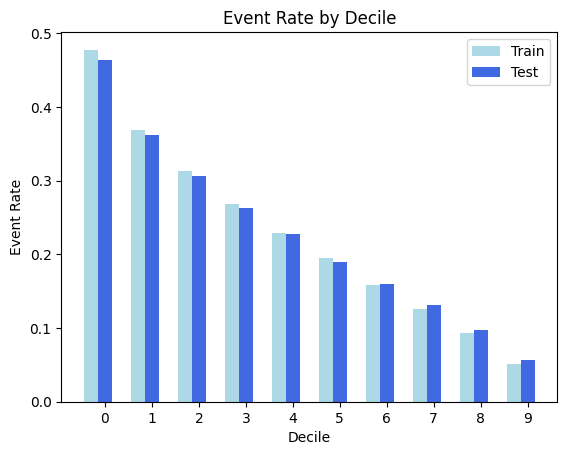

In [ ]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

Insight final:
- O Modelo é mais estável que o modelo 1 pois a diferença entre a barra de treino e teste em cada decil é menor que a do modelo anterior.
- O Modelo é mais performatico que o modelo 1 pois concentra mais mal pagadores nos primeiros decis que o modelo anterior, no decil 0 temos cerca de 46% de mal pagadores enquanto no modelo anterior tinhamos 39%.
- O Modelo aumentou o KS em 0,04 indo de 0,24 para 0,28.
- Mesmo com o aumento de KS ainda é considerando um valor ruim perto do benchmarking de mercado o que indica que existe oportundiade de melhoria.

## Salvar melhor modelo

In [ ]:
#salvando pickle do modelo para futura utilização. (teria que salvar pickles das etapas anteriores de pre-processamento de dados correto?)
import pickle

with open('vars_lgbm_2.pkl', 'wb') as f:
    pickle.dump(X_train_2_processed.columns, f)

with open('lgbm_2.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)